In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import pickle
from scipy import stats
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [3]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='x7sKaJ-AsrYaqyC65xz9ZxYLt1ATUb1BiYHnpqb0ZF-c',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'drug-donotdelete-pr-xa1anqlapgisyr'
object_key = 'drug200.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [6]:
# Shape of csv data
df.shape

(200, 6)

In [7]:
# Finding null values
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [8]:
# Checking the information of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [9]:
df.describe(include='all')

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
count,200.000000,200,200,200,200.000000,200
unique,NaN,2,3,2,NaN,5
top,NaN,M,HIGH,HIGH,NaN,DrugY
freq,NaN,104,77,103,NaN,91
mean,44.315000,NaN,NaN,NaN,16.084485,NaN
std,16.544315,NaN,NaN,NaN,7.223956,NaN
min,15.000000,NaN,NaN,NaN,6.269000,NaN
25%,31.000000,NaN,NaN,NaN,10.445500,NaN
50%,45.000000,NaN,NaN,NaN,13.936500,NaN
75%,58.000000,NaN,NaN,NaN,19.380000,NaN


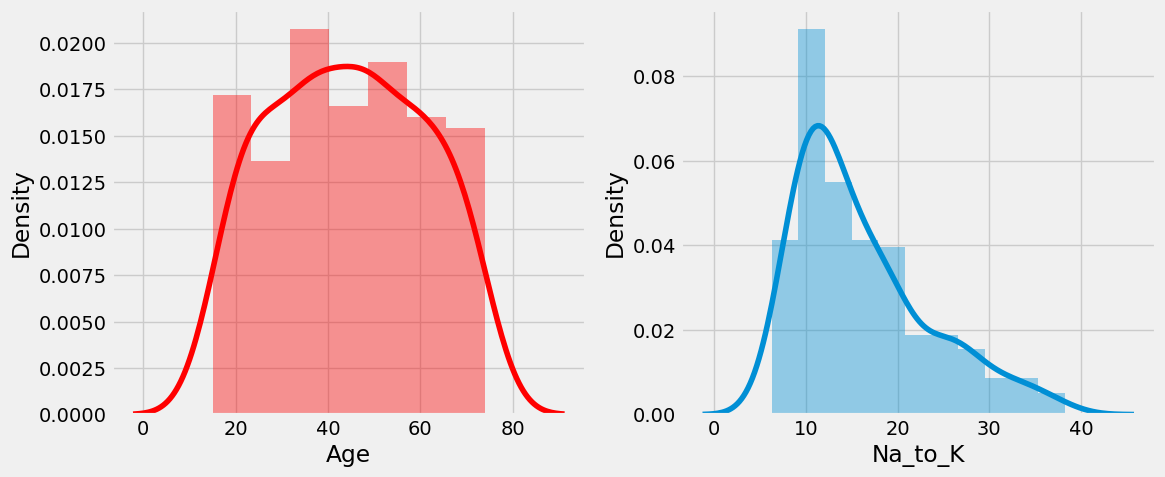

In [10]:
# Checking the distribution (normal or skewed)

plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(df['Age'],color='r')
plt.subplot(122)
sns.distplot(df['Na_to_K'])
plt.show()

In [11]:
# From the above plot age column is normally distributed. Na_to_k is right skewed (mean>mode). To overcome skewness transformation techniques can be used.

print(stats.mode(df['Na_to_K']))
print(np.mean(df['Na_to_K']))

ModeResult(mode=array([12.006]), count=array([2]))
16.08448499999999


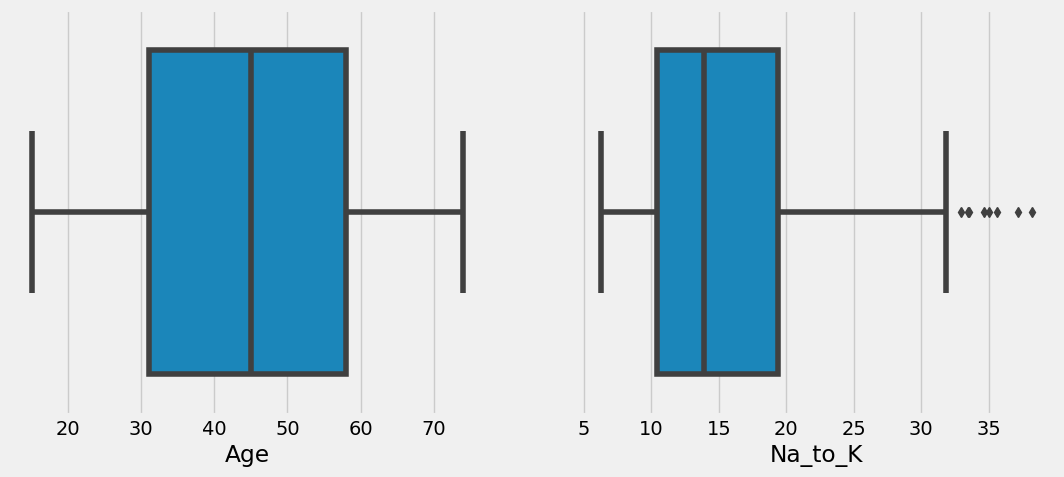

In [12]:
# Finding outliers

plt.figure(figsize=(12,5))
plt.subplot(121)
sns.boxplot(df['Age'])
plt.subplot(122)
sns.boxplot(df['Na_to_K'])
plt.show()

In [13]:
# Na_to_K has 8 outliers. In this project we are not going to handle outliers. Most of the classification algorithms are not sensitive to outliers.

q1 = np.quantile(df['Na_to_K'],0.25)
q3 = np.quantile(df['Na_to_K'],0.75)

IQR = q3-q1

upper_bound = q3+(1.5*IQR)

print('Upper Bound :',upper_bound)

print('Skewed data :',len(df[df['Na_to_K']>upper_bound]))

Upper Bound : 32.78175
Skewed data : 8


In [14]:
# Creating a data frame with categorical features for following visualization

df_cat = df.select_dtypes(include='object')
df_cat.head()

,Sex,BP,Cholesterol,Drug
0,F,HIGH,HIGH,DrugY
1,M,LOW,HIGH,drugC
2,M,LOW,HIGH,drugC
3,F,NORMAL,HIGH,drugX
4,F,LOW,HIGH,DrugY


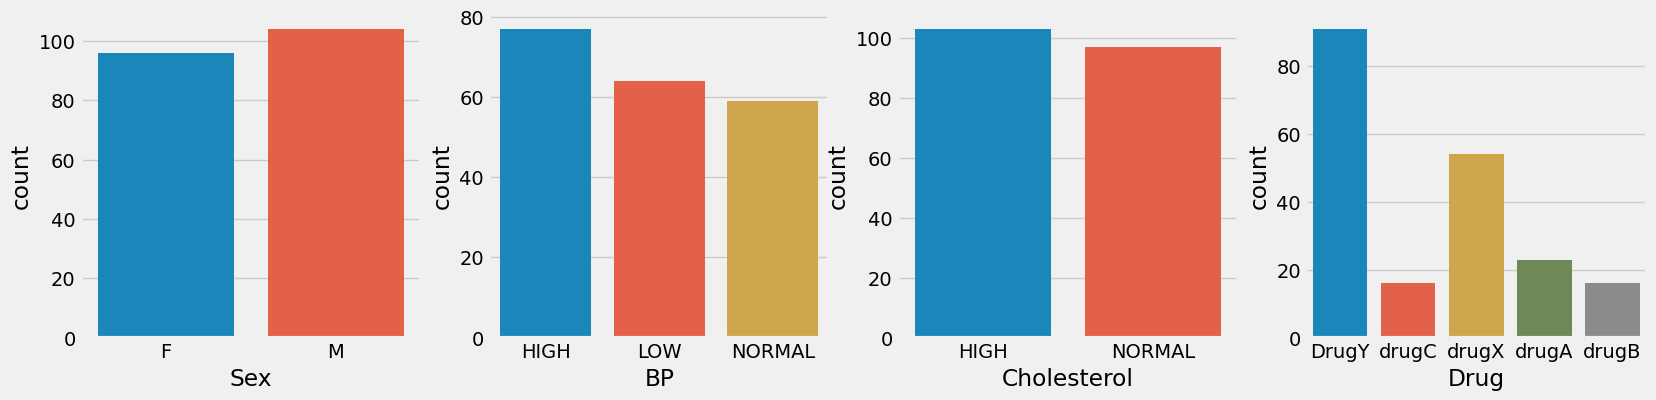

In [15]:
# Visualizing the count of categorical variable.

plt.figure(figsize=(18,4))
for i,j in enumerate(df_cat):
    plt.subplot(1,4,i+1)
    sns.countplot(df[j])   

In [16]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


<AxesSubplot:xlabel='Drug', ylabel='count'>

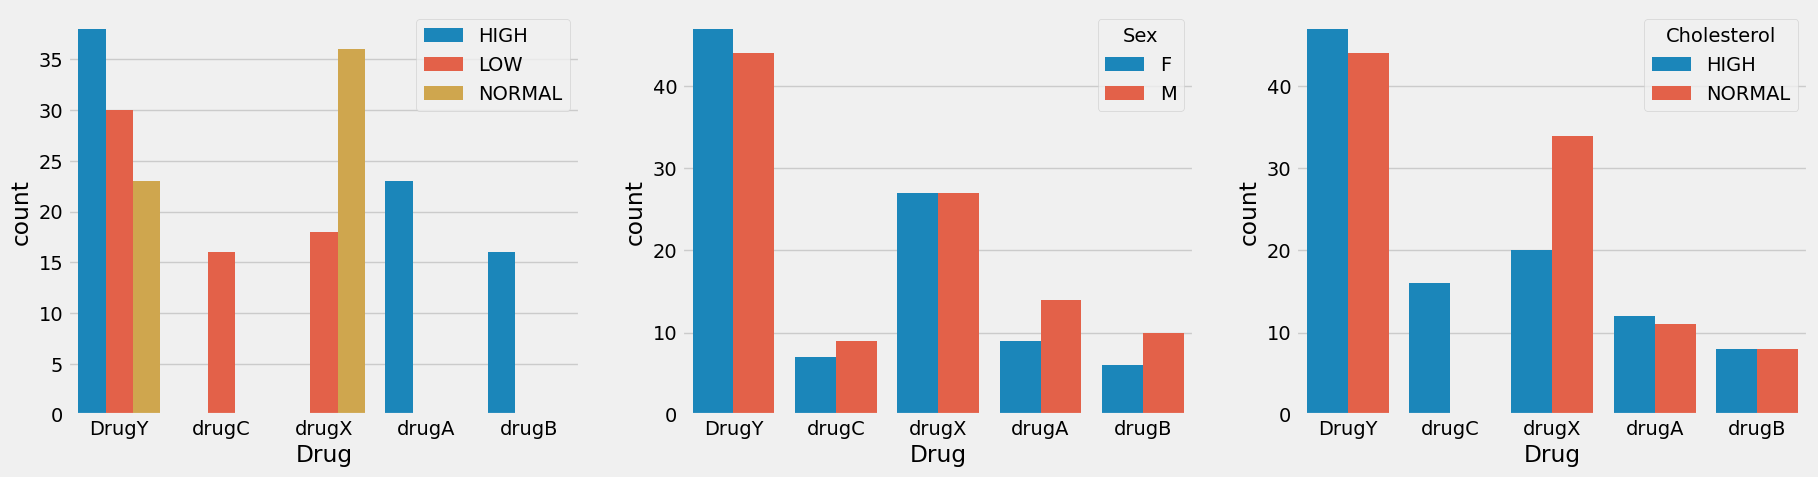

In [17]:
# Visualizing the relation between drug, BP, sex & cholesterol

plt.figure(figsize=(20,5))
plt.subplot(131)
sns.countplot(df['Drug'],hue=df['BP'])
plt.legend(loc='upper right')
plt.subplot(132)
sns.countplot(df['Drug'],hue=df['Sex'])
plt.subplot(133)
sns.countplot(df['Drug'],hue=df['Cholesterol'])

In [18]:
# Creating a new column Age_. This column shows the categorized age.

df['Age_'] = ['15-30' if x<=30 else '30-50' if x>30 and x<=50 else '50-75' for x in df['Age']]
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Age_
0,23,F,HIGH,HIGH,25.355,DrugY,15-30
1,47,M,LOW,HIGH,13.093,drugC,30-50
2,47,M,LOW,HIGH,10.114,drugC,30-50
3,28,F,NORMAL,HIGH,7.798,drugX,15-30
4,61,F,LOW,HIGH,18.043,DrugY,50-75


In [19]:
# Finding the relation between categorized age and drug

pd.crosstab(df['Age_'],[df['Drug']])

Drug,DrugY,drugA,drugB,drugC,drugX
Age_,,,,,
15-30,24,6,0,5,13
30-50,33,17,0,7,22
50-75,34,0,16,4,19


In [20]:
# Removing the Age_ column

df.drop('Age_',axis=1,inplace=True)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


<AxesSubplot:xlabel='Drug', ylabel='Na_to_K'>

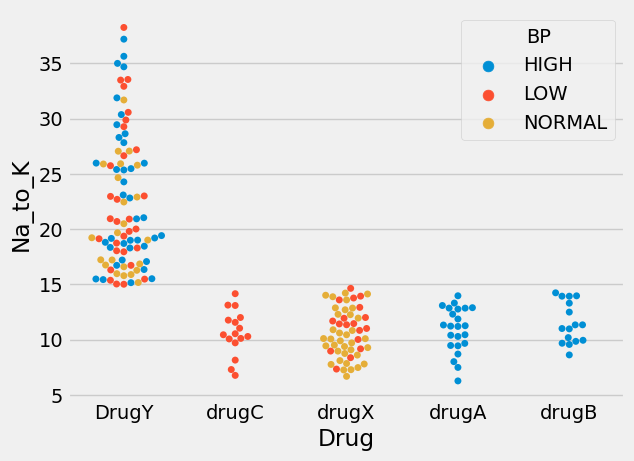

In [21]:
sns.swarmplot(df['Drug'],df['Na_to_K'],hue=df['BP'])

# DrugC is used for low BP patient, DrugY is used on patients having Na_to_K > 15.

In [22]:
# Replacing low, normal & high with 0, 1 & 2...

df['BP'] = [0 if x=='LOW' else 1 if x=='NORMAL' else 2 for x in df['BP']]

In [23]:
# Replacing normal and high cholesterol with 0 & 1

df['Cholesterol'] = [0 if x=='NORMAL' else 1 for x in df['Cholesterol']]

In [24]:
# Replacing female and male with 0 & 1

df['Sex'] = [0 if x=='F' else 1 for x in df['Sex']]

In [25]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,2,1,25.355,DrugY
1,47,1,0,1,13.093,drugC
2,47,1,0,1,10.114,drugC
3,28,0,1,1,7.798,drugX
4,61,0,0,1,18.043,DrugY


In [26]:
df['Drug'].value_counts()

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

In [27]:
x = df.drop('Drug',axis=1)
x.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0,2,1,25.355
1,47,1,0,1,13.093
2,47,1,0,1,10.114
3,28,0,1,1,7.798
4,61,0,0,1,18.043


In [28]:
y = df['Drug']
y.head()

0    DrugY
1    drugC
2    drugC
3    drugX
4    DrugY
Name: Drug, dtype: object

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

In [30]:
print('Shape of x_train {}'.format(x_train.shape))
print('Shape of y_train {}'.format(y_train.shape))
print('Shape of x_test {}'.format(x_test.shape))
print('Shape of y_test {}'.format(y_test.shape))

Shape of x_train (140, 5)
Shape of y_train (140,)
Shape of x_test (60, 5)
Shape of y_test (60,)


In [31]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

RandomForestClassifier()

In [32]:
ypred = rf.predict(x_test)

In [33]:
confusion_matrix(y_test,ypred)

array([[25,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0],
       [ 0,  2,  4,  0,  0],
       [ 0,  0,  0,  7,  0],
       [ 0,  0,  0,  0, 15]])

In [34]:
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        25
       drugA       0.78      1.00      0.88         7
       drugB       1.00      0.67      0.80         6
       drugC       1.00      1.00      1.00         7
       drugX       1.00      1.00      1.00        15

    accuracy                           0.97        60
   macro avg       0.96      0.93      0.93        60
weighted avg       0.97      0.97      0.97        60



In [35]:
pickle.dump(rf,open('model.pkl','wb'))

In [36]:
!pip install ibm_watson_machine_learning


In [37]:
from ibm_watson_machine_learning import APIClient
wml_credentials={
                    "url":"https://us-south.ml.cloud.ibm.com",
                    "apikey":"ekeuIk2TNfFCEym_f-b61LNFOG2YgHtnUok-XK92i1Q_"
                }
client=APIClient(wml_credentials)

In [38]:
def guid_from_space_name(client,space_name):
    space=client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"]== space_name)['metadata']['id'])

In [42]:
space_uid = guid_from_space_name(client, 'Drug classification')
print("Space UID = " + space_uid)

Space UID = 035b6119-dd50-4f77-bd90-00d4d3da6202


In [43]:
client.set.default_space(space_uid)

'SUCCESS'

In [44]:
import sklearn
sklearn.__version__

'1.1.1'

In [46]:
client.software_specifications.list()


-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [47]:
software_spec_uid= client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [48]:
model_details = client.repository.store_model(model=rf,meta_props={
                                client.repository.ModelMetaNames.NAME:"drug",
                                client.repository.ModelMetaNames.TYPE:"scikit-learn_1.0",
                                client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid},
                                              training_data=x_train,
                                              training_target=y_train)

In [49]:
model_id=client.repository.get_model_id(model_details)


In [50]:
model_id

'92b79300-6bfb-4d8e-b647-4279885adff7'

In [51]:
rf.predict([[25,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0],
       [ 0,  2,  4,  0,  0],
       [ 0,  0,  0,  7,  0],
       [ 0,  0,  0,  0, 15]])

array(['drugX', 'drugX', 'drugA', 'drugC', 'DrugY'], dtype=object)

In [52]:
model_details


{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'Drug',
  'schemas': {'input': [{'fields': [{'name': 'Age', 'type': 'int64'},
      {'name': 'Sex', 'type': 'int64'},
      {'name': 'BP', 'type': 'int64'},
      {'name': 'Cholesterol', 'type': 'int64'},
      {'name': 'Na_to_K', 'type': 'float64'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'training_data_references': [{'id': '1',
    'location': {},
    'schema': {'fields': [{'name': 'Age', 'type': 'int64'},
      {'name': 'Sex', 'type': 'int64'},
      {'name': 'BP', 'type': 'int64'},
      {'name': 'Cholesterol', 'type': 'int64'},
      {'name': 'Na_to_K', 'type': 'float64'}],
     'id': '1',
     'type': 'DataFrame'},
    'type': 'container'}],
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2023-02-10T08:08:46.562Z',
  'id': '92b79300-6bfb-4d8e-b647-4279885adff7',
  'modified_at': '2